In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import sys
base = '/home3/ebrahim/isr/'
sys.path.append(base)
from datasets import OneHotLetters
from torch.utils.data import Dataset, DataLoader
from model import RNN_feedback
torch.set_num_threads(2)
import seaborn as sns

In [2]:
def load_accuracy_loss_lists(path, title):
    
    accuracy_list = np.load(path + 'accuracy_list.npy')
    plt.plot(accuracy_list)
    plt.xlabel("Number of trials (tens of thousands)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()
    loss_list = np.load(path + 'loss_list.npy')
    plt.plot(loss_list)
    plt.xlabel("Number of trials (thousands)")
    plt.ylabel("Loss")
    plt.title(title)

    return accuracy_list



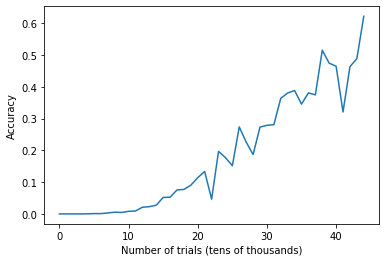

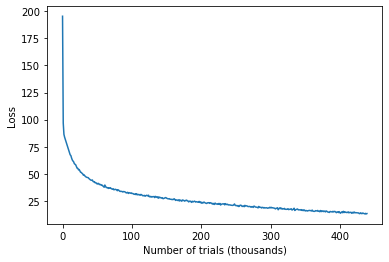

In [3]:
path = base + 'saved_models/simulation_one_grid/run_0.001_200/'
acc_list = load_accuracy_loss_lists(path, title='')